# Initial Experiments
## on Adaptive Dropout Probabilities via Tsetlin Machine-inspired Majority Voting

In this notebook I describe my idea, the first implementation, and the first results of basic exploratory analysis. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn


Here is my first version of the new dropout, nicknamed Tsetlin Unit dropout. The process really has nothing to do with Tsetlin Automata or Machines other than that there is a majority vote in a later version, but I was inspired by them!
It works by assigning each unit or input an individual probability of being dropped, and iteratively changing these probabilities after each gradient update. 

Personally, I find working with the "keep" probabilities (1 - dropout probability) a bit more intuitive, so I have defaulted to using them in the equations. 

To that end, if the network classification was incorrect, the keep probability of any given unit/input is updated by the function:
$$
{p}_{t+1} = p_{t} - \alpha (p_{t}-1)exp(-p_{t})  
$$
..., where p is the keep probability at update t and alpha is a max step size hyperparameter. And updated by the equation:

$$
{p}_{t+1} = p_{t} - \alpha (p_{t})exp(p_{t}-1) 
$$
...if the network classification was correct. 

These rules update the probabilities less towards their relative extremes, i.e. if a probability is being increased, and it is already near 1, then it is only going to increase by a tiny amount, but if it were near 0, it would increase by a relatively large amount, and visa-versa for approaching 0. 

In code, it looked like this:



In [4]:
class TsetlinUnitDropoutLegacy(nn.Module):  # Drops units rather than weights
    def __init__(self, in_size, init_prob, max_step):
        super().__init__()
        assert 0 <= init_prob < 1
        self.max_step = max_step
        self.probabilities = torch.nn.Parameter(torch.tensor(np.full((1, in_size), init_prob, dtype="float32")),
                                                requires_grad=False) 
        self.not_dropped = [] 

    def forward(self, inp):
        if inp.shape != self.probabilities.shape:  # This makes sure the probabilities are copied to match batch size
            self.probabilities = torch.nn.Parameter(torch.tensor(np.tile(self.probabilities[0], (inp.shape[0], 1))),
                                                    requires_grad=False)
            assert inp.shape == self.probabilities.shape
        mask = (torch.rand(inp.shape[1]) < self.probabilities).float()  # compares rand nums to probability of being
        # included
        # Assign not_dropped indices of prob tensor whose unit WAS included in network (These will be updated at step)
        self.not_dropped = [batch_el.nonzero(as_tuple=True) for batch_el in mask]  # To be indexed with
        # TODO consider flattening into 1d and then get indices somehow?
        return mask * inp / self.probabilities  # inverted dropout scaling

    def update_probs(self, correct_list):  # This implementation penalizes (increases dropout prob) if correct
        for i in range(len(correct_list)):
            if correct_list[i]:  # decrease chance of inclusion (increase dropout prob) if correct
                self.probabilities[i][self.not_dropped[i]] -= self.probabilities[i][self.not_dropped[i]] * self.max_step / torch.exp(1 - self.probabilities[i][self.not_dropped[i]])
            else:  # this number is subtracting a negative ie. increase chance of inclusion (decrease dropout prob)
                self.probabilities[i][self.not_dropped[i]] -= self.max_step * (self.probabilities[i][self.not_dropped[i]] - 1) / torch.exp(self.probabilities[i][self.not_dropped[i]])

TLDR: Find which probabilities in the structure were used, then when its time to update, iterate over that list to update the probabilities based on whether they contributed to a correct classification or not. 

From a 10000-foot view, dropout's job is to combat overfitting, so it should make things more difficult. Correct classifications LOWER the keep probability (increase chance of dropping out) because I want to make it harder for the network to correctly classify, and incorrect classifications RAISED the keep probability for the same reason.  


Here is how the model performed on the MNIST dataset. This is an average of 50 runs over 10 epochs, with 4 layers with 512 units each. There was a batch size of 64 with learning rate 0.001 and no momentum. 

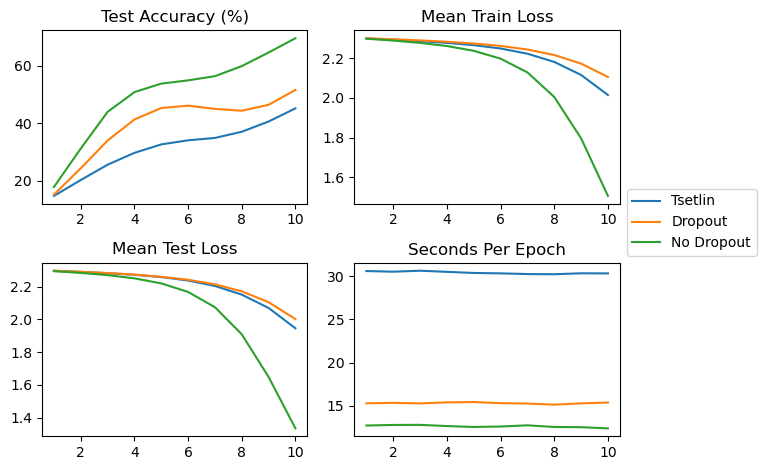

In [50]:
tsetdf = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTTsetlin50x10.csv")
dropdf = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTDropout50x10.csv")
nodropdf = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTNoDropout50x10.csv")
meantf = [tsetdf[tsetdf["Epoch"] == i]["Test Acc(%)"].mean() for i in range(1,11)]
meandr = [dropdf[dropdf["Epoch"] == i]["Test Acc(%)"].mean() for i in range(1,11)]
meanno = [nodropdf[nodropdf["Epoch"] == i]["Test Acc(%)"].mean() for i in range(1,11)]
# mean Test Acc
x = np.arange(1,11)
plt.subplot(2,2,1)
plt.plot(x,meantf,label = "Tsetlin")
plt.plot(x,meandr,label = "Dropout")
plt.plot(x, meanno, label = "No Dropout")
plt.title("Test Accuracy (%)")

# mean Train Loss
meantf = [tsetdf[tsetdf["Epoch"] == i]["Mean Train Loss"].mean() for i in range(1,11)]
meandr = [dropdf[dropdf["Epoch"] == i]["Mean Train Loss"].mean() for i in range(1,11)]
meanno = [nodropdf[nodropdf["Epoch"] == i]["Mean Train Loss"].mean() for i in range(1,11)]
plt.subplot(2,2,2)
plt.plot(x,meantf,label = "Tsetlin")
plt.plot(x,meandr,label = "Dropout")
plt.plot(x, meanno, label = "No Dropout")
plt.title("Mean Train Loss")

# mean Test Loss

meantf = [tsetdf[tsetdf["Epoch"] == i]["Mean Test Loss"].mean() for i in range(1,11)]
meandr = [dropdf[dropdf["Epoch"] == i]["Mean Test Loss"].mean() for i in range(1,11)]
meanno = [nodropdf[nodropdf["Epoch"] == i]["Mean Test Loss"].mean() for i in range(1,11)]
plt.subplot(2,2,3)
plt.plot(x,meantf,label = "Tsetlin")
plt.plot(x,meandr,label = "Dropout")
plt.plot(x, meanno, label = "No Dropout")
plt.title("Mean Test Loss")

# mean train Time
meantf = [tsetdf[tsetdf["Epoch"] == i]["Time Per Epoch(s)"].mean() for i in range(1,11)]
meandr = [dropdf[dropdf["Epoch"] == i]["Time Per Epoch(s)"].mean() for i in range(1,11)]
meanno = [nodropdf[nodropdf["Epoch"] == i]["Time Per Epoch(s)"].mean() for i in range(1,11)]
plt.subplot(2,2,4)
plt.plot(x,meantf,label = "Tsetlin")
plt.plot(x,meandr,label = "Dropout")
plt.plot(x, meanno, label = "No Dropout")
plt.title("Seconds Per Epoch")

plt.tight_layout()
plt.legend(loc="lower left",bbox_to_anchor=(1,1))

With this architecture and hyperparameters, the "Tsetlin" dropout not only took significantly longer to train (on the cpu), but also had less accuracy on the validation set in every epoch, despite having a lower loss value than standard dropout. Not looking good. But what did the probability look like?

Below shows the keep probability of an arbitrary unit in a sample run, and the mean of the above 50 runs. The probability max step size parameter was 0.1 (note, the probability step value is scaled by 0.1, so it never actually moves by 0.1 unless at the extreme value of 0 or 1 depending on the formula, where the output would otherwise be 1)

Text(0.5, 1.0, 'Average Probability')

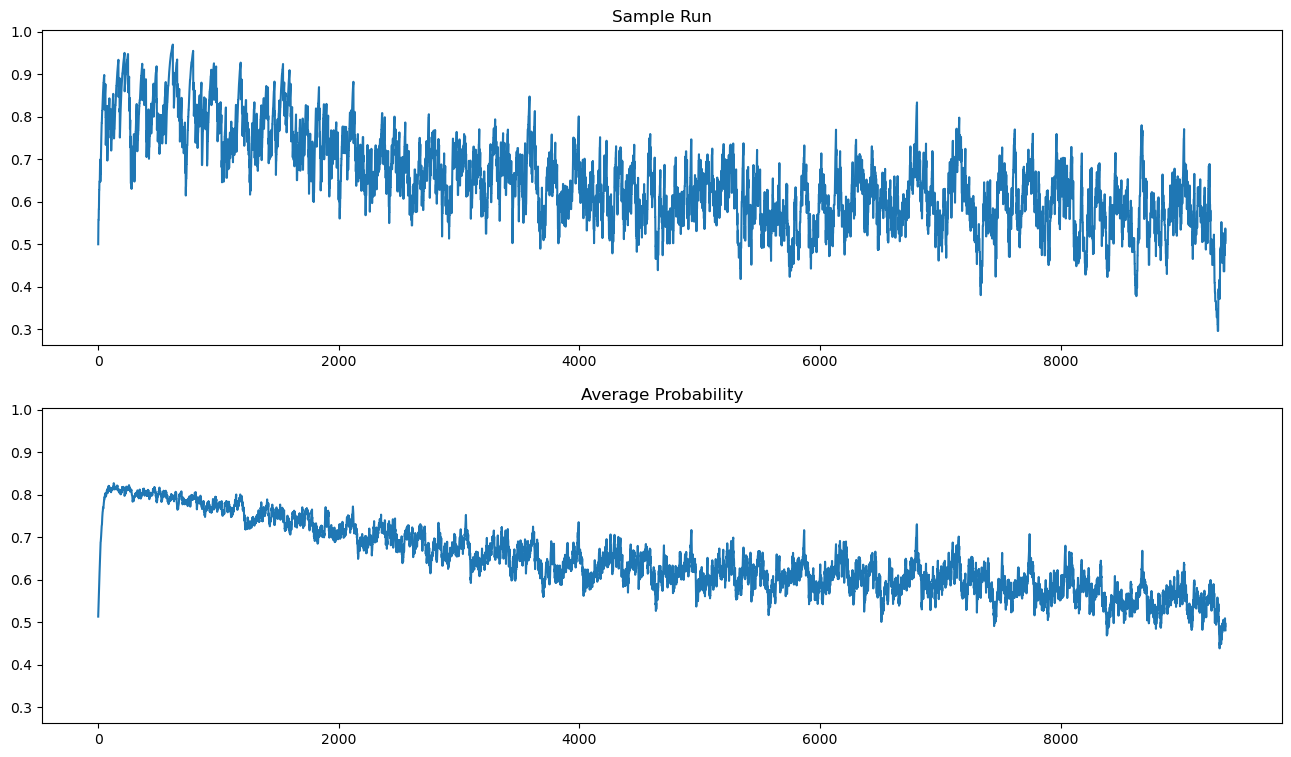

In [35]:
probs_frame = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTTsetlin50x10Probs.csv")
sample_run = probs_frame[probs_frame.Run == 3]
temp = [probs_frame[probs_frame.Run == i]["Keep Probability"] for i in range(50)]
prob_array = np.array(temp)
mean_prob = prob_array.mean(axis=0)

fig, axs = plt.subplots(2,1,figsize=(16,9),sharey=True)
axs[0].plot(np.arange(9370), sample_run["Keep Probability"])
axs[0].set_title("Sample Run")
axs[1].plot(np.arange(9370),mean_prob)
axs[1].set_title("Average Probability")

The trend shows that the probability of being included shoots up, rapidly fluctuates, and descends over time. Interstingly, one can see approx. 10 evenly spaced upwards spikes towards the beginning of each epoch. This is an effect of not shuffling your training data!

Naturally, I wanted to know how the networks would perform at a longer time scale. Would the difference in train and validation losses between regular dropout and tsetlin dropout come into play in the future? How do the networks generalize? 

The next graphs show the networks at 100 training epochs each, with the same hyperparameters and architecture as before. These are not averages, just individual sample runs. Training took so long, I only did one of these so I could do more experiments and make changes. 

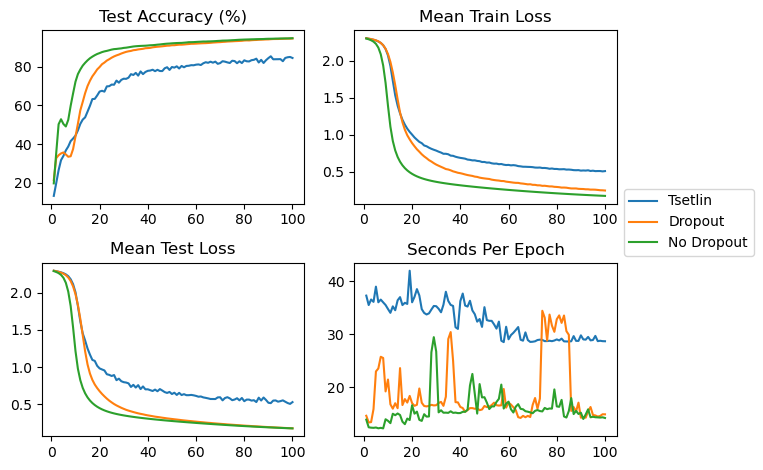

In [49]:
#### Change the PATH to the correct location for you! ####

tset100 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTTsetlinDropout100x1.csv")
drop100 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTDropout1x100.csv")
nodrop100 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTNoDropout1x100.csv")
x = np.arange(1,101)
fig, ax = plt.subplots(2,2)

ax[0,0].plot(x,tset100["Test Acc(%)"],label = "Tsetlin")
ax[0,0].plot(x,drop100["Test Acc(%)"],label = "Dropout")
ax[0,0].plot(x,nodrop100["Test Acc(%)"], label = "No Dropout")
ax[0,0].set_title("Test Accuracy (%)")

# mean Train Loss
ax[0,1].plot(x,tset100["Mean Train Loss"],label = "Tsetlin")
ax[0,1].plot(x,drop100["Mean Train Loss"],label = "Dropout")
ax[0,1].plot(x,nodrop100["Mean Train Loss"], label = "No Dropout")
ax[0,1].set_title("Mean Train Loss")

# mean Test Loss
ax[1,0].plot(x,tset100["Mean Test Loss"],label = "Tsetlin")
ax[1,0].plot(x,drop100["Mean Test Loss"],label = "Dropout")
ax[1,0].plot(x,nodrop100["Mean Test Loss"], label = "No Dropout")
ax[1,0].set_title("Mean Test Loss")

# mean train Time
ax[1,1].plot(x,tset100["Time Per Epoch(s)"],label = "Tsetlin")
ax[1,1].plot(x,drop100["Time Per Epoch(s)"],label = "Dropout")
ax[1,1].plot(x,nodrop100["Time Per Epoch(s)"], label = "No Dropout")
ax[1,1].set_title("Seconds Per Epoch")


plt.tight_layout()
plt.legend(loc="lower left",bbox_to_anchor=(1,1))

Again, this is just one sample, but the different is pretty stark. The "Tsetlin" dropout makes it too hard for the network to effectively train. 

Here is the sample unit's probability graph from this run:

count    93700.000000
mean         0.317158
std          0.151560
min          0.037103
25%          0.215029
50%          0.284843
75%          0.377064
max          0.973213
Name: Keep Probability, dtype: float64

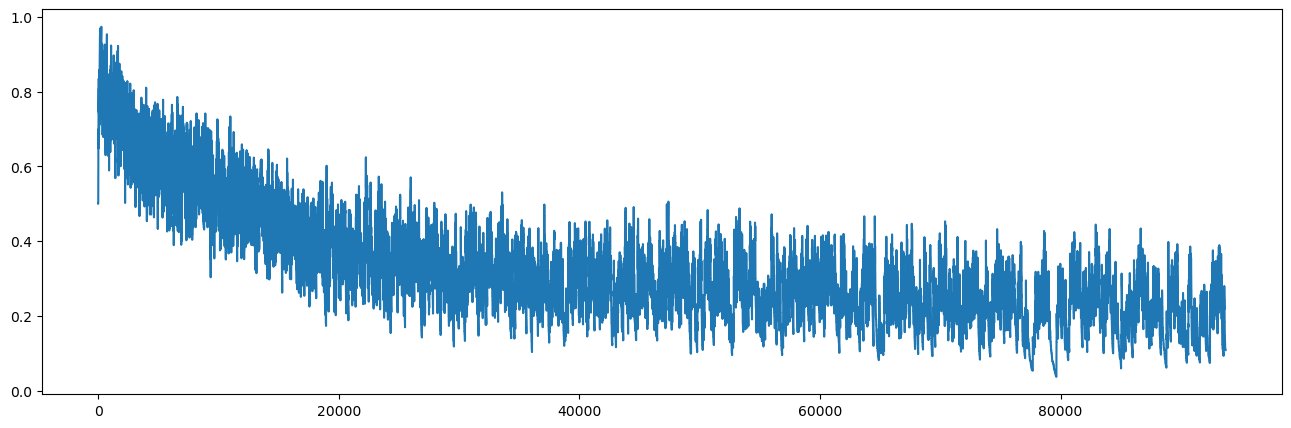

In [57]:
probs100 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTTsetlinDropout100x1_probs.csv")
probs100['Keep Probability'].plot(figsize=(16, 5))
display(probs100["Keep Probability"].describe())

Here are my first looks at different values for alpha, 0.05 and 0.25. Again, not super insightful without multiple trials, but I was checking for any very significant differences and not finding them. Oddly enough, 0.25 seems to have done the best. that is a HUGE step size!

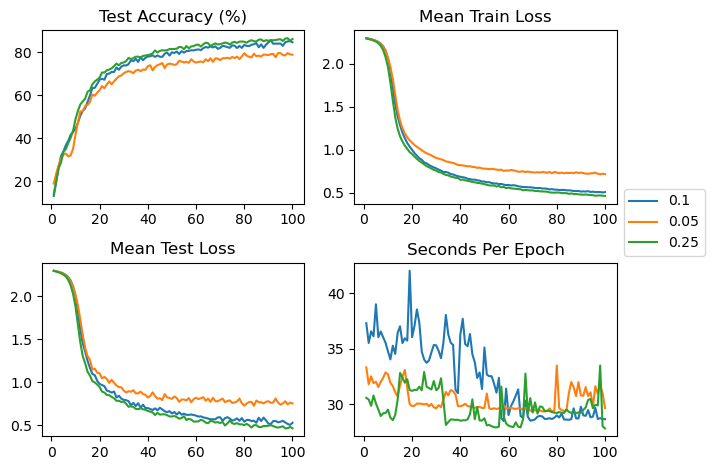

In [61]:
step05 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTmaxStep025.csv")
step025 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTTsetlinMaxStep05_1x100.csv")
x = np.arange(1,101)
fig, ax = plt.subplots(2,2)

ax[0,0].plot(x,tset100["Test Acc(%)"],label = "0.1")
ax[0,0].plot(x,step05["Test Acc(%)"],label = "0.05")
ax[0,0].plot(x,step025["Test Acc(%)"], label = "0.25")
ax[0,0].set_title("Test Accuracy (%)")

# mean Train Loss
ax[0,1].plot(x,tset100["Mean Train Loss"],label = "0.1")
ax[0,1].plot(x,step05["Mean Train Loss"],label = "0.05")
ax[0,1].plot(x,step025["Mean Train Loss"], label = "0.25")
ax[0,1].set_title("Mean Train Loss")

# mean Test Loss
ax[1,0].plot(x,tset100["Mean Test Loss"],label = "0.1")
ax[1,0].plot(x,step05["Mean Test Loss"],label = "0.05")
ax[1,0].plot(x,step025["Mean Test Loss"], label = "0.25")
ax[1,0].set_title("Mean Test Loss")

# mean train Time
ax[1,1].plot(x,tset100["Time Per Epoch(s)"],label = "0.1")
ax[1,1].plot(x,step05["Time Per Epoch(s)"],label = "0.05")
ax[1,1].plot(x,step025["Time Per Epoch(s)"], label = "0.25")
ax[1,1].set_title("Seconds Per Epoch")


plt.tight_layout()
plt.legend(loc="lower left",bbox_to_anchor=(1,1))


Text(0.5, 1.0, '0.25')

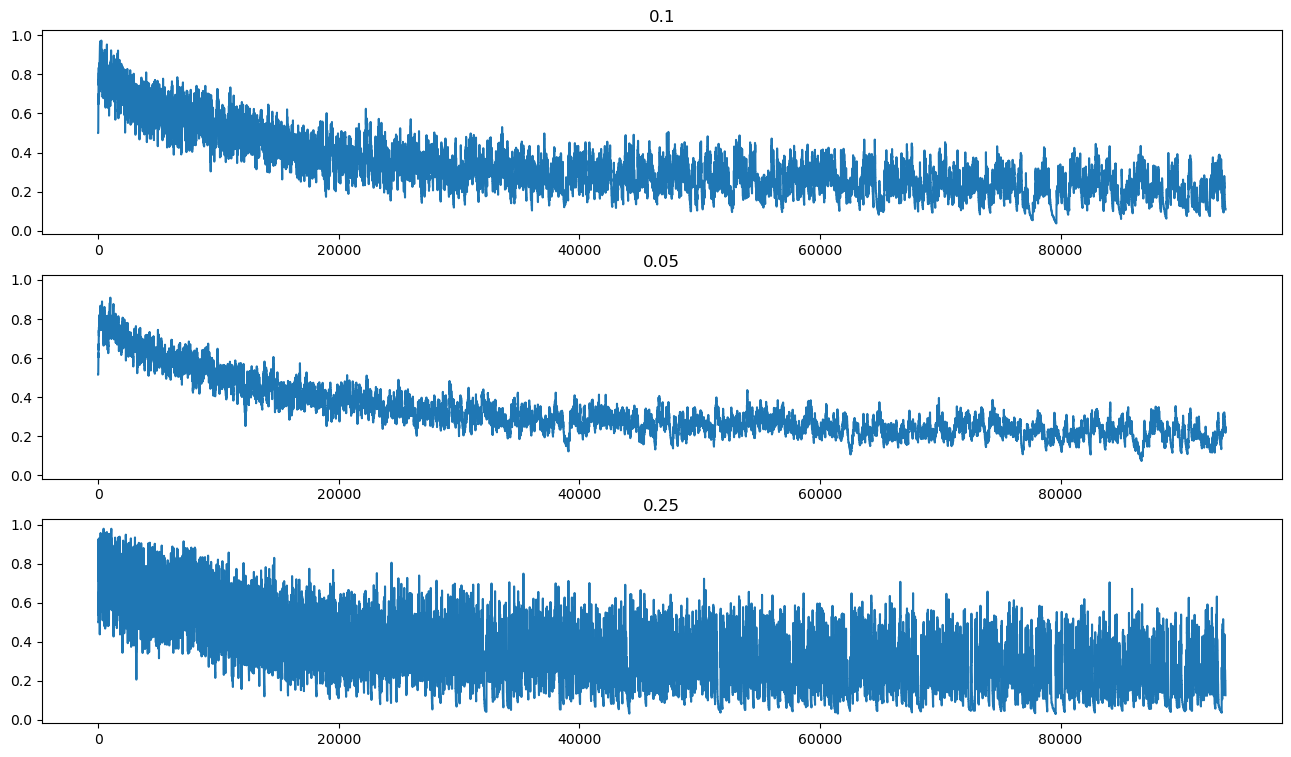

In [62]:
probs05 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTTsetlinMAXSTEP05_1x100_probs.csv")
probs025 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\512 Model\MNISTMaxStep025_probs.csv")


fig, axs = plt.subplots(3,1,figsize=(16,9),sharey=True)
axs[0].plot(np.arange(93700), probs100["Keep Probability"])
axs[0].set_title("0.1")
axs[1].plot(np.arange(93700),probs05["Keep Probability"])
axs[1].set_title("0.05")
axs[2].plot(np.arange(93700),probs025["Keep Probability"])
axs[2].set_title("0.25")

### Conclusions

After these initial experiments, I decided "tsetlin" dropout makes it too difficult to train on even a simple dataset like MNIST (I also did these experiments on the FMNIST dataset to relatively similar results). I found the "arc" of the keep probability interesting, as it generally followed the same shape: rapidly increase keep probability when the network is very inaccurate and slowly decrease over time until the network begins to get things significantly wrong again. This trend will continue. 


These initial experiments were insightful, but left me with the impression that some things had to change. Most importantly, this version of "tsetlin" was SUPER slow, and didn't play nicely with GPUs. This was because it needed to loop over the entire batch several times, both to do the dropping out, and to update the probabilities. Additionally, the probabilities had a high variance, since they would be updated batch size number of times at each update. In my next version I addressed both of these concerns.

